<h1> Taxi Fare Prediction using Keras </h1>

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

In [2]:
# File Path
TRAIN_PATH = 'tf_train.csv'
TEST_PATH = 'test_processed.csv'

In [3]:
CSV_COLUMNS = ['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
               'dropoff_latitude', 'passenger_count', 'year', 'month', 'day', 'hour', 'weekday', 'night', 'late_night']
LABEL_COLUMN = 'fare_amount'
DEFAULTS = [['nokey'], [1.0], ['2009-06-15 17:26:21 UTC'], [-74.0], [40.0], [-74.0], [40.7], [1.0], [2009], [6], [15],
            [17], [1], [1], [1]]

In [4]:
def process(df):
    df['pickup_longitude_binned'] = pd.qcut(df['pickup_longitude'], 16, labels=False)
    df['dropoff_longitude_binned'] = pd.qcut(df['dropoff_longitude'], 16, labels=False)
    df['pickup_latitude_binned'] = pd.qcut(df['pickup_latitude'], 16, labels=False)
    df['dropoff_latitude_binned'] = pd.qcut(df['dropoff_latitude'], 16, labels=False)

    df = df.drop('pickup_datetime', axis=1)

    return df

In [5]:
def manhattan(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    return np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)

In [6]:
def add_relevant_distances(df):
    # Add airpot distances and downtown
    ny = (-74.0063889, 40.7141667)
    jfk = (-73.7822222222, 40.6441666667)
    ewr = (-74.175, 40.69)
    lgr = (-73.87, 40.77)
    df['downtown_pickup_distance'] = manhattan(ny[1], ny[0], df['pickup_latitude'], df['pickup_longitude'])
    df['downtown_dropoff_distance'] = manhattan(ny[1], ny[0], df['dropoff_latitude'], df['dropoff_longitude'])
    df['jfk_pickup_distance'] = manhattan(jfk[1], jfk[0], df['pickup_latitude'], df['pickup_longitude'])
    df['jfk_dropoff_distance'] = manhattan(jfk[1], jfk[0], df['dropoff_latitude'], df['dropoff_longitude'])
    df['ewr_pickup_distance'] = manhattan(ewr[1], ewr[0], df['pickup_latitude'], df['pickup_longitude'])
    df['ewr_dropoff_distance'] = manhattan(ewr[1], ewr[0], df['dropoff_latitude'], df['dropoff_longitude'])
    df['lgr_pickup_distance'] = manhattan(lgr[1], lgr[0], df['pickup_latitude'], df['pickup_longitude'])
    df['lgr_dropoff_distance'] = manhattan(lgr[1], lgr[0], df['dropoff_latitude'], df['dropoff_longitude'])

    return df

In [7]:
def add_engineered(df):
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']

    latdiff = (lat1 - lat2)
    londiff = (lon1 - lon2)
    euclidean = (latdiff ** 2 + londiff ** 2) ** 0.5

    # Add new features
    df['latdiff'] = latdiff
    df['londiff'] = londiff
    df['euclidean'] = euclidean
    df['manhattan'] = manhattan(lat1, lon1, lat2, lon2)

    # One-hot encoding columns
    # Note, this is note the best way to one-hot encode features, but probably the simplest and will work here
    df = pd.get_dummies(df, columns=['weekday'])
    df = pd.get_dummies(df, columns=['month'])

    return df

In [8]:
# Load values in a more compact form
dtype_train = {'key': 'str',
             'fare_amount': 'float32',
             'pickup_datetime': 'str',
             'pickup_longitude': 'float32',
             'pickup_latitude': 'float32',
             'dropoff_longitude': 'float32',
             'dropoff_latitude': 'float32',
             'passenger_count': 'uint8',
             'year': 'uint16',
             'month': 'uint8',
             'day': 'uint8',
             'hour': 'uint8',
             'weekday': 'uint8',
             'night': 'uint8',
             'late_night': 'uint8'}

dnames_train = ['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
              'passenger_count', 'year', 'month', 'day', 'hour', 'weekday', 'night', 'late_night']

dtype_test = {'key': 'str',
             'pickup_datetime': 'str',
             'pickup_longitude': 'float32',
             'pickup_latitude': 'float32',
             'dropoff_longitude': 'float32',
             'dropoff_latitude': 'float32',
             'passenger_count': 'uint8',
             'year': 'uint16',
             'month': 'uint8',
             'day': 'uint8',
             'hour': 'uint8',
             'weekday': 'uint8',
             'night': 'uint8',
             'late_night': 'uint8'}

dnames_test = ['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
              'passenger_count', 'year', 'month', 'day', 'hour', 'weekday', 'night', 'late_night']

In [9]:
train = pd.read_csv(TRAIN_PATH, names=dnames_train, dtype=dtype_train, usecols=[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14])
test = pd.read_csv(TEST_PATH, names=dnames_test, dtype=dtype_test, usecols=[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13])

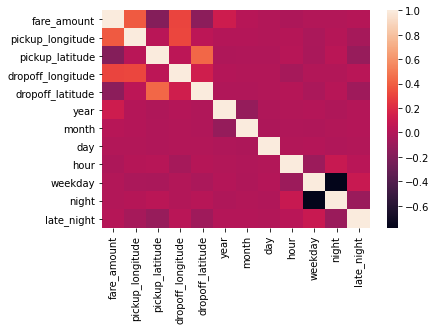

In [10]:
sns.heatmap(train.corr())
plt.show()

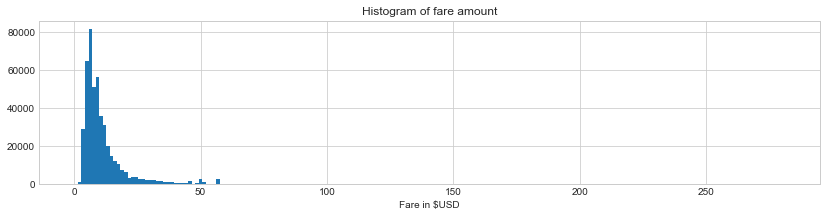

In [11]:
# matplotlib inline
plt.style.use('seaborn-whitegrid')

# Plot histogram of fare
train.fare_amount.hist(bins=200, figsize=(14,3))
plt.xlabel('Fare in $USD')
plt.title('Histogram of fare amount');

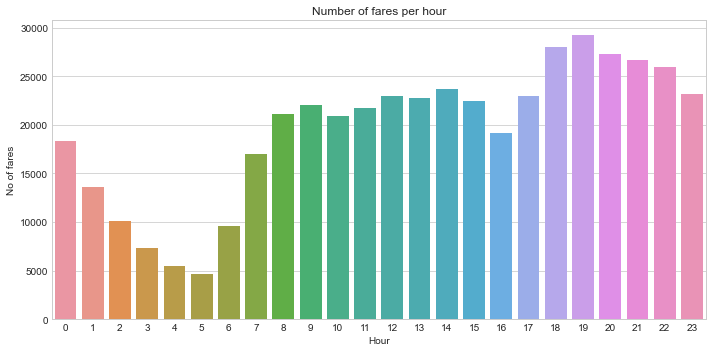

In [12]:
# Plot histogram of fares per hour
plt.figure(figsize = (10,5))
train_2 = train.groupby('hour', as_index = False)['fare_amount'].agg(['count']).sort_values(by = 'hour', ascending = True)
ax = sns.barplot(x=train_2.index, y=train_2['count'])
ax.set(xlabel='Hour', ylabel='No of fares')  
plt.title('Number of fares per hour')
plt.tight_layout()
plt.show()
del train_2

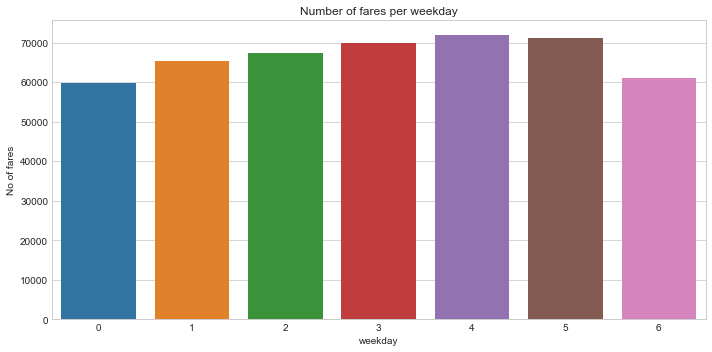

In [13]:
# Plot histogram of fares per weekday
plt.figure(figsize = (10,5))
train_3 = train.groupby('weekday', as_index = False)['fare_amount'].agg(['count']).sort_values(by = 'weekday', ascending = True)
ax = sns.barplot(x=train_3.index, y=train_3['count'])
ax.set(xlabel='weekday', ylabel='No of fares')  
plt.title('Number of fares per weekday')
plt.tight_layout()
plt.show()
del train_3

In [14]:
# process data
train = process(train)
test = process(test)

train = add_relevant_distances(train)
test = add_relevant_distances(test)

train = add_engineered(train)
test = add_engineered(test)

# Drop unwanted columns
dropped_columns = ['pickup_longitude', 'pickup_latitude',
                   'dropoff_longitude', 'dropoff_latitude']
train_clean = train.drop(dropped_columns, axis=1)
test_clean = test.drop(dropped_columns + ['key'], axis=1)

In [15]:
# Split data in train and validation (80% and 20%)
train_df, validation_df = train_test_split(train_clean, test_size=0.2, random_state=1)

In [16]:
# Get labels
train_labels = train_df['fare_amount'].values
validation_labels = validation_df['fare_amount'].values
train_df = train_df.drop(['fare_amount'], axis=1)
validation_df = validation_df.drop(['fare_amount'], axis=1)

In [17]:
# Scale data
scaler = preprocessing.MinMaxScaler()
train_df_scaled = scaler.fit_transform(train_df).astype(np.float32)
validation_df_scaled = scaler.transform(validation_df).astype(np.float32)
test_scaled = scaler.transform(test_clean).astype(np.float32)

In [18]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(512, activation='relu', input_shape=(train_df_scaled.shape[1],), name='raw'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1, activation='linear', name='predictions'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
raw (Dense)                  (None, 512)               20992     
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8

In [20]:
# Hyperparameters
LEARNING_RATE = 0.0001
STEPS = 200000
BATCH_SIZE = 512

In [21]:
adam = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss="mae", optimizer=adam, metrics=['mae', 'mse'])

In [22]:
history = model.fit(train_df_scaled, train_labels, batch_size = BATCH_SIZE, epochs = 25, validation_data=(validation_df_scaled, validation_labels))

Epoch 1/25
729/729 [==============================] - 46s 44ms/step - loss: 11.2402 - mae: 11.2402 - mse: 220.3956 - val_loss: 10.6617 - val_mae: 10.6617 - val_mse: 206.5674
Epoch 2/25
729/729 [==============================] - 27s 37ms/step - loss: 10.5856 - mae: 10.5856 - mse: 205.7097 - val_loss: 9.8122 - val_mae: 9.8122 - val_mse: 188.6620
Epoch 3/25
729/729 [==============================] - 26s 36ms/step - loss: 9.5807 - mae: 9.5807 - mse: 185.1857 - val_loss: 8.6270 - val_mae: 8.6270 - val_mse: 166.1565
Epoch 4/25
729/729 [==============================] - 24s 33ms/step - loss: 8.2734 - mae: 8.2734 - mse: 160.0407 - val_loss: 7.2114 - val_mae: 7.2114 - val_mse: 137.7748
Epoch 5/25
729/729 [==============================] - 24s 33ms/step - loss: 6.8385 - mae: 6.8385 - mse: 128.5484 - val_loss: 5.5023 - val_mae: 5.5023 - val_mse: 97.6685
Epoch 6/25
729/729 [==============================] - 26s 35ms/step - loss: 5.1771 - mae: 5.1771 - mse: 88.3544 - val_loss: 3.6552 - val_mae: 3.6

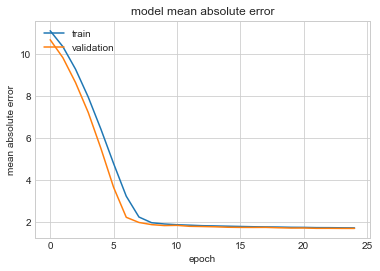

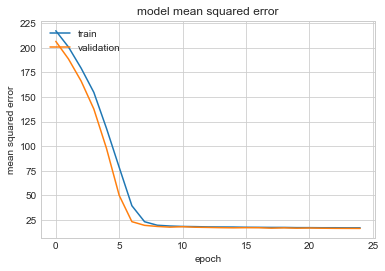

In [25]:
# summarize history for mean absolute error
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mean absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for mean squared error
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mean squared error')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [26]:
# try using test file
test_prediction = model.predict(test_scaled)
print(test_prediction)

[[11.387528 ]
 [10.549087 ]
 [ 4.3842483]
 ...
 [56.927246 ]
 [20.592335 ]
 [ 6.638538 ]]


In [27]:
# Save model to pb (protocol buffer) format
model.save('keras_model')

INFO:tensorflow:Assets written to: keras_model\assets


In [28]:
# Save model to h5 (hdf5) format
model.save('keras_model.h5')

In [ ]:
# Convert model to json format
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    --signature_name=serving_default \
    --saved_model_tags=serve \
    ./keras_model \
    ./keras_model/json_model

In [ ]:
# Convert model to tflite format
converter = tf.lite.TFLiteConverter.from_saved_model("./keras_model") # path to the SavedModel directory
tflite_model = converter.convert()
with open('model.tflite', 'wb') as file:
    file.write(tflite_model)